In [3]:
# Import Libraries
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt

C:\Users\User\AppData\Local\Temp\ipykernel_48116\3862532798.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [1]:
data_dir = r'C:\Users\User\ODL Ass\bird25'
img_height, img_width = 224, 224
BATCH_SIZE = 32

In [ ]:
# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  
    color_mode='rgb',
    subset='validation'
)


Found 30000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


In [ ]:
# TensorBoard Callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
# Define  hypermodel
def build_model(hp):
    base_model = tf.keras.applications.InceptionResNetV2(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Define the second dense layer units
    second_dense_units = hp.Choice('second_dense_units', [ 64, 128, 256, 512])
    # First dense layer units is twice the second dense layer units
    first_dense_units = second_dense_units * 2 
    # Define dropout rate hyperparameter
    dropout_rate = hp.Choice('dropout_rate', [0.5, 0.6])
    # First dense layer with hyperparameters
    x = tf.keras.layers.Dense(
        units=first_dense_units)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Second dense layer with hyperparameters
    x = tf.keras.layers.Dense(
        units=second_dense_units)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x) 
    outputs = tf.keras.layers.Dense(25, activation='softmax')(x)  
    model = tf.keras.Model(inputs, outputs)
    model.base_model = base_model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tuner set up 
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='bird25_dir',
    project_name='InceptionResNetV2_tuning'
)

# EarlyStopping and ReduceLROnPlateau callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
model_check = tf.keras.callbacks.ModelCheckpoint('Tuned_TLInceptionResNetV3_model.keras', monitor='val_loss', save_best_only=True)

#Hyperparameter search
tuner.search(train_generator, validation_data=validation_generator, epochs=20, callbacks=[stop_early, reduce_lr])

# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense layer is {best_hps.get('second_dense_units') * 2}, 
the optimal number of units in the second dense layer is {best_hps.get('second_dense_units')}, 
and the optimal dropout rate for both dense layers is {best_hps.get('dropout_rate')}.
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[tensorboard_callback, stop_early, reduce_lr, model_check])

# Fine-tuning
fine_tune_at = 100 
model.base_model.trainable = True

for layer in model.base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_generator,
                         validation_data=validation_generator,
                         epochs=10,
                         callbacks=[tensorboard_callback, stop_early, reduce_lr,model_check])

C:\Users\User\AppData\Local\Temp\ipykernel_12228\649640528.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from bird25_dir\InceptionResNetV2_tuning\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first dense layer is 1024, 
the optimal number of units in the second dense layer is 512, 
and the optimal dropout rate for both dense layers is 0.6.


Epoch 1/20


d:\ananconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 1571s 2s/step - accuracy: 0.4232 - loss: 2.3266 - val_accuracy: 0.8157 - val_loss: 0.6047 - learning_rate: 1.0000e-04
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1277s 1s/step - accuracy: 0.6643 - loss: 1.1774 - val_accuracy: 0.8397 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1210s 1s/step - accuracy: 0.7064 - loss: 1.0238 - val_accuracy: 0.8575 - val_loss: 0.4837 - learning_rate: 1.0000e-04
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1210s 1s/step - accuracy: 0.7300 - loss: 0.9394 - val_accuracy: 0.8552 - val_loss: 0.4819 - learning_rate: 1.0000e-04
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1211s 1s/step - accuracy: 0.7457 - loss: 0.8867 - val_accuracy: 0.8652 - val_loss: 0.4533 - learning_rate: 1.0000e-04
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1210s 1s/step - accuracy: 0.7538 - loss: 0.8407 - val_accuracy: 0.8619 - val_loss: 0.4582 - learning_rate: 1.0000e-04
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1223s 1s/step - accurac

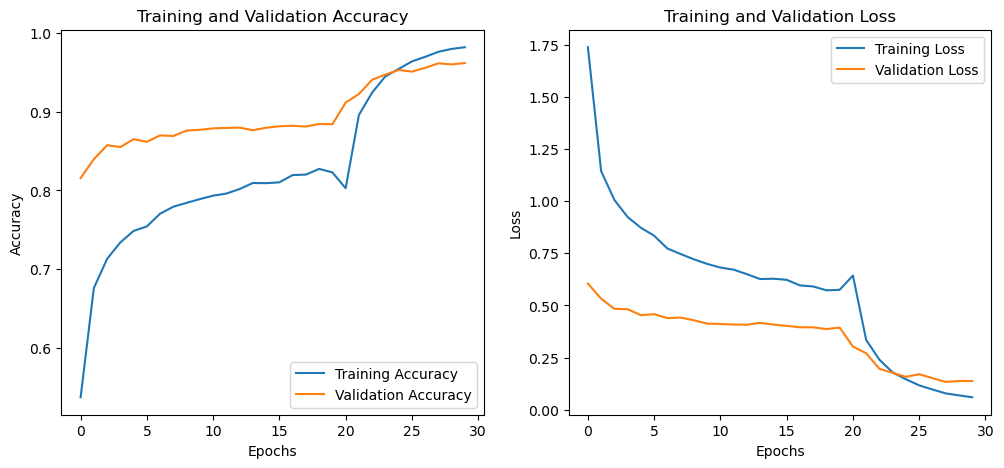

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine):
    # Extracting data from the initial training phase
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extracting data from the fine-tuning phase
    acc_fine = history_fine.history['accuracy']
    val_acc_fine = history_fine.history['val_accuracy']
    loss_fine = history_fine.history['loss']
    val_loss_fine = history_fine.history['val_loss']

    # Combining data for complete training process
    total_acc = acc + acc_fine
    total_val_acc = val_acc + val_acc_fine
    total_loss = loss + loss_fine
    total_val_loss = val_loss + val_loss_fine

    # Total epochs
    total_epochs = range(len(total_acc))

    # Plotting accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs, total_acc, label='Training Accuracy')
    plt.plot(total_epochs, total_val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs, total_loss, label='Training Loss')
    plt.plot(total_epochs, total_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot the training history
plot_training_history(history, history_fine)


In [ ]:
# Load the model
model = tf.keras.models.load_model('Tuned_TLInceptionResNetV3_model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)

# Print evaluation results
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


235/235 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9602 - loss: 0.1294
Validation Loss: 0.13348853588104248
Validation Accuracy: 0.9616000056266785


In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
# Load the model
model = tf.keras.models.load_model('Tuned_TLInceptionResNetV3_model.keras')

# Make predictions on the validation set
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute F1 score, precision, and recall
f1 = f1_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Print evaluation results
print(f"Validation F1 Score: {f1}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

# Detailed classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

235/235 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step
Validation F1 Score: 0.9616546026688204
Validation Precision: 0.9620709786792467
Validation Recall: 0.9616
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.98      0.96      0.97       300
      Brown-Headed-Barbet       0.96      0.94      0.95       300
             Cattle-Egret       0.98      1.00      0.99       300
        Common-Kingfisher       0.99      0.98      0.99       300
              Common-Myna       0.97      0.97      0.97       300
         Common-Rosefinch       0.86      0.92      0.89       300
        Common-Tailorbird       0.93      0.96      0.94       300
       Coppersmith-Barbet       0.98      0.92      0.95       300
           Forest-Wagtail       0.96      0.93      0.94       300
             Gray-Wagtail       0.97      0.96      0.96       300
                   Hoopoe       0.99      0.98      0.98       300
               House-Crow       0.95      0.93